# Тетрадка содержит примеры запуска скриптов для оптимизации маршрутов инкассирования банкоматов

# Подробное описание алгоритма https://docs.google.com/document/d/19ftHeXtqAmW5It6GZB7rXeG6sPUV7aQRcBvD6-6h00k/edit?usp=sharing

In [44]:
%load_ext autoreload


import os
import pandas as pd

# Кастомная библиотека, созданная для хакатона - модкли лежат в папке src
from bank_schedule import dataclaster, optim, output, check_conditions
from bank_schedule import plot as bsplot
from bank_schedule import scheduler, ortools_tsp, output
from bank_schedule.cluster import clusterize_atm
from bank_schedule.data import Data
from bank_schedule.forecast import train_lgbm_models, load_model
from bank_schedule.constants import RAW_DATA_FOLDER, INTERIM_DATA_FOLDER

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Загрузка данных

Внимание: данные надо класть в папку ```/bank_schedule/data/raw```
(```data/raw/Params.xlsx,  data/raw/terminal_data_hackathon v4.xlsx, data/raw/times v4.csv```)


In [5]:
# В эту папку требуется положить 3 файла:
# Params.xlsx - набор основных констант(лежит в bank_schedule/data/raw)
# terminal_data_hackathon v4.xlsx - Как в задании
# times v4.csv - Как в задании
PATH_TO_DATA_FOLDER = RAW_DATA_FOLDER
print(RAW_DATA_FOLDER)

# Интерфейс для доступа к данным
data = dataclaster.DataClaster(RAW_DATA_FOLDER)

# Определение количества машин

## Прогноз

Для определения количества машин на различных гиперпараметрах запускали алгоритм жадной оптимизации маршрутов. Благодаря высокой скорости расчета на различных параметрах (размерах кластера, параметрах оптимизатора расписаний, параметров отбора ближайших к опорным банкоматам соседей) получили следующие результаты

(код см. в тетрадке ```notebooks/optimization_researches.ipynb```)

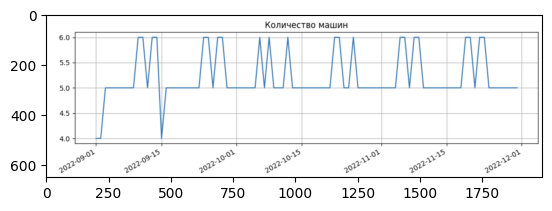

In [45]:
car_img = plt.imread(os.path.join(INTERIM_DATA_FOLDER, 'cars_count.png'))
plt.imshow(car_img, zorder=0, aspect='equal')

In [46]:
# видим, что оптимальное количество машин = 6
cars_quant = 6

## Определение кол-ва машин

# Кластеризация

Пример разделения всех банкоматов на кластеры с помощью KMeansConstrained. Особенность алгоритма - позволяет ограничивать размеры кластеров и настраивать их так, чтобы количество сэмплов было одинаковым

Подробнее - в тетрадке ```notebooks/clust_researches.ipynb```

In [36]:
data.run_cluster(0.01, cars_quant)

loader = Data(RAW_DATA_FOLDER)

geo_df = loader.get_geo_TIDS()
clusterized = clusterize_atm(loader, 6, allowed_percent=.01)
clusterized = clusterized.merge(geo_df)
bsplot.geoplot_clusters(clusterized, 'label', html_folder=INTERIM_DATA_FOLDER)

# Эвристическая оптимизация

Обучение модели прогноза пополнений производится вызовом функции ```forecast/train_lgbm_models()```
Переобучать модель не требуется, но при необходимости это возможно

Загружаем обученную модель

In [8]:
lgbm_model = load_model('lgbm')

Загружаем данные, на которых можем тестироваться и рассчитать метрики

In [9]:
loader = Data(RAW_DATA_FOLDER)
in_df = loader.get_money_in()

Строим прогнозы и считаем метрики

In [22]:
n_periods = 14
predictions = lgbm_model.predict('2022-10-30', n_periods)
display(predictions.head())

,date,TID,money_in
0,2022-10-31,406136,85942.749663
1,2022-10-31,406139,145946.108882
2,2022-10-31,406145,112694.489416
3,2022-10-31,406148,65073.362363
4,2022-10-31,406180,72617.351326


In [47]:
result_df = predictions.merge(in_df, how='left', on=['date', 'TID'], suffixes=('_predicted', '_true'))
result_df.set_index('date', inplace=True)

mae = mean_absolute_error(result_df['money_in_true'],
                          result_df['money_in_predicted'])

print(f'Mean Absolute Error: {round(mae, 2)}')

mape = mean_absolute_percentage_error(
    result_df.loc[result_df['money_in_true'] != 0, 'money_in_true'],
    result_df.loc[result_df['money_in_true'] != 0, 'money_in_predicted']
    )

print(f'Mean Absolute Percentage Error: {round(mape, 2)}')

Mean Absolute Error: 11217.88
Mean Absolute Percentage Error: 0.23


## Эвристическая оптимизация: подготовка расписания инкассации по дням

In [17]:
schedule_df = \
    scheduler.prepare_schedule(
        loader, # загрузчик данных
        forecast_horizon=30, # горизонт прогноза при ежедневном обновлении расписания
        deadline_threshold=1, # за сколько дней до "дедлайна" инкассировать банкоматы
        atms_per_day_min=150, # сколько банкоматов минимум надо объехать задень
        neighborhood_radius=15, # в каком радиусе времени пути банкоматы подходят для попутного объезда
        use_greedy_scheduler=False, # использовать жадный настройщик расписания
        use_real_data_for_update=True, # использовать реальные данные для обновления расписания
        last_collection_method='constant', # как проставлять дату последней инкассации в файле остатков
        forecast_model_name='lgbm', # какую модель использовать для прогноза
        end_date='2022-11-30' # какой датой закончить прогноз (дата начала берется из файла остатков)
        )

/Users/affernus/PROJECTS/hacks/bank_schedule/src/bank_schedule/forecast.py:265: UserWarning: Дата 2022-08-31 00:00:00 не найдена в данных, прогнозируем средним по TID
  warn(f'Дата {today_date} не найдена в данных, прогнозируем средним по TID')


In [19]:
display(schedule_df.head())

,TID,money,date,last_collection_date,overflow_date,days_to_deadline,is_mandatory
0,644823,137000,2022-09-01,2022-08-31,NaT,14,0
1,669434,298000,2022-09-01,2022-08-31,2022-09-19,14,0
2,649162,137000,2022-09-01,2022-08-31,2022-09-18,14,0
3,644742,327000,2022-09-01,2022-08-31,2022-09-22,14,0
4,636008,52000,2022-09-01,2022-08-31,2022-09-27,14,0


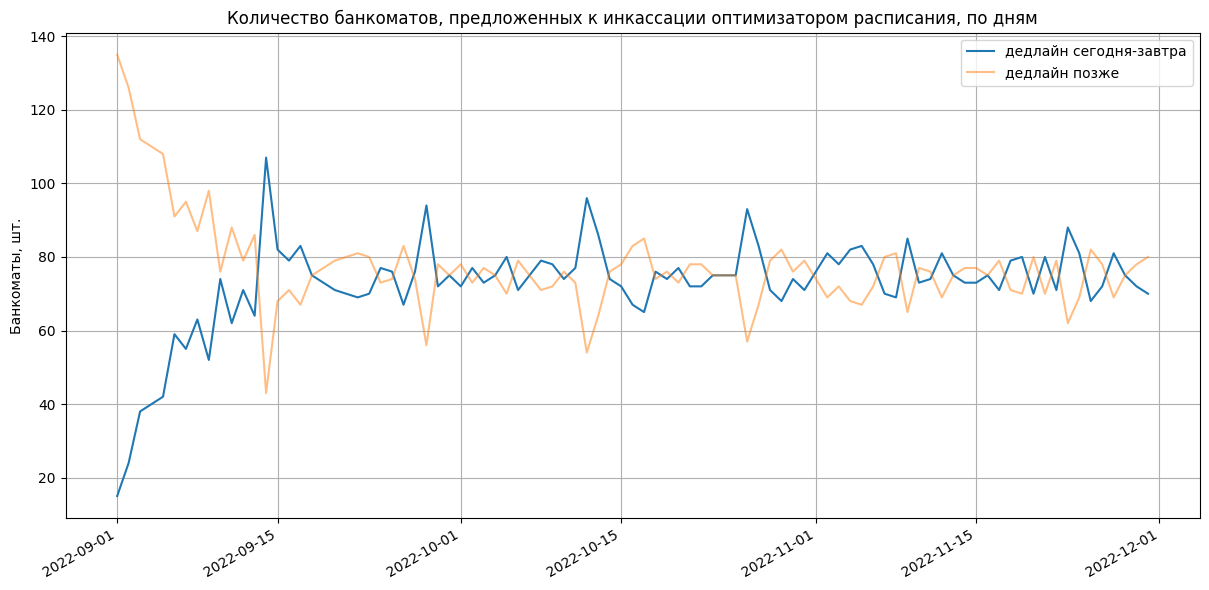

In [24]:
mandatory_atms_ts = schedule_df.groupby('date')['is_mandatory'].sum()
other_atms_series = schedule_df.groupby('date')['is_mandatory'].count() - mandatory_atms_ts

fig, ax = plt.subplots(figsize=(12, 6))
plt.plot(pd.Series(mandatory_atms_ts), label='дедлайн сегодня-завтра')
plt.plot(pd.Series(other_atms_series), label='дедлайн позже', alpha=.5)
plt.title('Количество банкоматов, предложенных к инкассации оптимизатором расписания, по дням')
fig.autofmt_xdate()
plt.tight_layout()
plt.legend()
plt.ylabel('Банкоматы, шт.')
plt.grid()
plt.show()

## Эвристическая оптимизация: построение оптимальных маршрутов согласно расписанию

In [26]:
car_routes_dict, cars_routes_times_dict = \
    ortools_tsp.optimize_routes(loader, # загрузчик данных
                                schedule_df, # датафрейм с расписанием инкассации
                                n_iterations=1, # количество итераций построения маршрута. Выбирается лучшее решение из полученных
                                max_route_time=719.5, # максимально допустимое время маршрута в минутах для одного броневика
                                verbose=True) # выводит в консоль информацию о процессе

date: 2022-09-01 00:00:00 | max route time: 718.57 | max route time: 347.77 | number of cars: 4 | ATMs visited: 150
date: 2022-09-02 00:00:00 | max route time: 712.12 | max route time: 526.41 | number of cars: 4 | ATMs visited: 150
date: 2022-09-03 00:00:00 | max route time: 713.31 | max route time: 442.12 | number of cars: 5 | ATMs visited: 150
date: 2022-09-04 00:00:00 | max route time: 715.69 | max route time: 217.0  | number of cars: 5 | ATMs visited: 150
date: 2022-09-05 00:00:00 | max route time: 717.8  | max route time: 210.28 | number of cars: 5 | ATMs visited: 150
date: 2022-09-06 00:00:00 | max route time: 717.47 | max route time: 486.74 | number of cars: 5 | ATMs visited: 150
date: 2022-09-07 00:00:00 | max route time: 717.27 | max route time: 516.04 | number of cars: 5 | ATMs visited: 150
date: 2022-09-08 00:00:00 | max route time: 717.65 | max route time: 699.55 | number of cars: 5 | ATMs visited: 150
date: 2022-09-09 00:00:00 | max route time: 715.5  | max route time: 322

In [49]:
result_df = ortools_tsp.prepare_tsp_result(car_routes_dict)
display(result_df.head())

,number,TID,date,auto
0,0,627712,2022-09-01,1
1,1,658915,2022-09-01,1
2,2,688325,2022-09-01,1
3,3,628631,2022-09-01,1
4,4,609485,2022-09-01,1


# Подготовка отчета по эвристической оптимизации

In [50]:
df_routes = output.find_routes_check_2(result_df, loader) # проверка ограничений на время (с 8 утра до 8 вечера) + составления маршрутов для отчета
df_opt_result = df_routes[['TID','date','auto']]

check_conditions.condition_max_days_inc(df_opt_result,  loader)
check_conditions.check_over_balance(df_opt_result,  loader)

df_money_sum = output.find_ATM_balance_evening(df_opt_result, loader) 
df_money_sum_morning = output.find_ATM_balance_morning(df_opt_result, loader) 
all_cost_by_days, all_cost_inc, df_fond = output.find_all_cost(df_money_sum, df_opt_result, loader) 

# создание отчета
output.postprocessing_and_make_excel('heuristic optimisation.xlsx',
                                     df_money_sum_morning,
                                     df_fond,
                                     all_cost_inc,
                                     all_cost_by_days,
                                     df_routes)

find routes for auto=1
find routes for auto=2
find routes for auto=3
find routes for auto=4
find routes for auto=5
find routes for auto=6
find routes for auto=7


100%|██████████| 91/91 [00:14<00:00,  6.12it/s]


# MILP оптимизация

In [ ]:
%autoreload 2

# Решение может искаться долго(до 6 часов),но зато показывает в средним результаты лучше, чем у эвристической оптимизации

milp_optim_results = []
for cluster_num in range(cars_quant):
    presolved_models, presolved_results = optim.run_milp_optim(data, date(2022, 9, 1), 2, cluster_num)
    milp_optim_results.append((presolved_models, presolved_results, cluster_num))


# Подготовка отчета по MILP оптимизации

## Проверка ограничений

In [ ]:
# Вынимаем маршруты из внутреннего представления
# Проверка ограничений на время (с 8 утра до 8 вечера) + составления маршрутов для отчета
df_routes = output.find_routes_check(milp_optim_results, data)
df_opt_result = df_routes[['TID','date','auto']]

# Проверка ограничения на инкассации каждые 14 дней
check_conditions.condition_max_days_inc(df_opt_result,  data)

# Проверка ограничения на максимальную допустимую сумму в банкоматах
check_conditions.check_over_balance(df_opt_result,  data)

## Подготовка отчета

In [ ]:
%autoreload 2
# Создание отчета
df_money_sum = output.find_ATM_balance_evening(df_opt_result, data) 
df_money_sum_morning = output.find_ATM_balance_morning(df_opt_result, data) 
all_cost_by_days, all_cost_inc, df_fond = output.find_all_cost(df_money_sum, df_opt_result, data) 

output.postprocessing_and_make_excel('MILP optimisation.xlsx', df_money_sum_morning, df_fond, all_cost_inc, all_cost_by_days, df_routes)